## Dataloader

In [1]:
import numpy as np
from tqdm import tqdm
import torch
import os

In [2]:
import torch.utils.data as data

class PointCloudDataset(data.Dataset):

    def __init__(self,target_files,phase,transform,label_dict):
        self.transform=transform
        self.target_files=target_files
        self.class_label = label_dict

    def __len__(self):
        return len(self.target_files)

    def __getitem__(self,index):
        pcd,one_hot = self.pull_item(index)
        return pcd,one_hot

    def pull_item(self,index):
        self.path=self.target_files[index]

        #label
        label = int(self.class_label[self.path[1:3]])

        #load_pcd
        pcd = np.load('DATA/MSRAction_npz_pp/' + self.path,allow_pickle=True)['point_clouds']
        pcd = torch.from_numpy(pcd.astype(np.float32)).clone()
        pcd = torch.nn.functional.normalize(pcd, p=2.0, dim=0, eps=1e-12)
        #pcd=self.transform(pcd)
        return pcd, label

In [3]:
#行動にラベルを付与
from collections import defaultdict
input_dir = 'DATA/MSRAction_npz_pp'
files = os.listdir(input_dir)


label_dict = dict()
label_num = defaultdict(int)
class_set = set()
num_class = 0

for file in files:
    action = file[1:3]
    microactivity = action
    label_num[microactivity]+=1
    if microactivity not in class_set:
        label_dict[microactivity] = num_class
        num_class+=1
        class_set.add(microactivity)
print(label_dict)
print(label_num)

{'17': 0, '14': 1, '16': 2, '12': 3, '13': 4, '03': 5, '05': 6, '10': 7, '19': 8, '06': 9, '01': 10, '08': 11, '18': 12, '02': 13, '09': 14, '20': 15, '04': 16, '07': 17, '11': 18, '15': 19}
defaultdict(<class 'int'>, {'17': 30, '14': 30, '16': 30, '12': 30, '13': 30, '03': 27, '05': 26, '10': 30, '19': 30, '06': 26, '01': 27, '08': 30, '18': 30, '02': 27, '09': 30, '20': 30, '04': 26, '07': 28, '11': 30, '15': 20})


In [4]:
train_files = [a for a in files if a[10] == '3']
test_files = [a for a in files if a[10] != '3']

In [6]:
n_samples = len(train_files)
train_size = int(n_samples * 0.8)
val_size = n_samples - train_size

trainval_dataset = PointCloudDataset(target_files=train_files,phase='train',transform=None,label_dict=label_dict)
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size,val_size])
test_dataset = PointCloudDataset(target_files=test_files,phase='train',transform=None,label_dict=label_dict)

## MODEL

In [7]:
from torch_geometric.nn import global_max_pool
import torch.nn as nn

In [8]:
class InputTNet(nn.Module):
    def __init__(self):
        super(InputTNet, self).__init__()
        self.input_mlp = nn.Sequential(
            nn.Linear(3, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
        )
        self.output_mlp = nn.Sequential(
            nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(),
            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(),
            nn.Linear(256, 9)
        )
        
    def forward(self, x, batch):
        x = self.input_mlp(x)
        x = global_max_pool(x, batch)
        x = self.output_mlp(x)
        x = x.view(-1, 3, 3)
        id_matrix = torch.eye(3).to(x.device).view(1, 3, 3).repeat(x.shape[0], 1, 1)
        x = id_matrix + x
        return x

In [9]:
class FeatureTNet(nn.Module):
    def __init__(self):
        super(FeatureTNet, self).__init__()
        self.input_mlp = nn.Sequential(
            nn.Linear(64, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
        )
        self.output_mlp = nn.Sequential(
            nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(),
            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(),
            nn.Linear(256, 64*64)
        )
        
    def forward(self, x, batch):
        x = self.input_mlp(x)
        x = global_max_pool(x, batch)
        x = self.output_mlp(x)
        x = x.view(-1, 64, 64)
        id_matrix = torch.eye(64).to(x.device).view(1, 64, 64).repeat(x.shape[0], 1, 1)
        x = id_matrix + x
        return x

In [10]:
class PointNetClassification(nn.Module):
    def __init__(self):
        super(PointNetClassification, self).__init__()
        self.input_tnet = InputTNet()
        self.mlp1 = nn.Sequential(
            nn.Linear(3, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 64), nn.BatchNorm1d(64), nn.ReLU(),
        )
        self.feature_tnet = FeatureTNet()
        self.mlp2 = nn.Sequential(
            nn.Linear(64, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
        )
        self.mlp3 = nn.Sequential(
            nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(p=0.3),
            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(p=0.3),
            nn.Linear(256, 20)
        )
        
    def forward(self, batch_data,batch_label):
        x = batch_data
        input_transform = self.input_tnet(x, batch_label)
        transform = input_transform[batch_label, :, :]
        x = torch.bmm(transform, x.view(-1, 3, 1)).view(-1, 3)
        
        x = self.mlp1(x)
        
        feature_transform = self.feature_tnet(x, batch_label)
        transform = feature_transform[batch_label, :, :]
        x = torch.bmm(transform, x.view(-1, 64, 1)).view(-1, 64)

        x = self.mlp2(x)        
        x = global_max_pool(x,batch_label)
        x = self.mlp3(x)
        
        return x, input_transform, feature_transform

In [12]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.data import DataLoader as DataLoader

num_epoch = 150
batch_size = 32

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = PointNetClassification()
model = model.to(device)

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epoch // 4, gamma=0.5)

log_dir = "logs/log_MSR_classification"
#log_dir.mkdir(exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criteria = torch.nn.CrossEntropyLoss()

In [13]:
from tqdm import tqdm

for epoch in tqdm(range(num_epoch)):
    model = model.train()
    
    losses = []
    for batch_data, y in tqdm(train_dataloader, total=len(train_dataloader)):
        this_batch_size =  len(y)

        batch_label = torch.zeros([this_batch_size*1024])
        for i in range(this_batch_size):
            batch_label[1024 * i : 1024 * (i + 1)] = i

        batch_data = batch_data.reshape((1024 * this_batch_size,3)).to(device)
        batch_label = batch_label.type(torch.LongTensor).to(device)
        pred_y, _, feature_transform = model(batch_data, batch_label)
        true_y = y.detach().to(device)

        class_loss = criteria(pred_y, true_y)
        accuracy = float((pred_y.argmax(dim=1) == true_y).sum()) / float(this_batch_size)

        id_matrix = torch.eye(feature_transform.shape[1]).to(feature_transform.device).view(1, 64, 64).repeat(feature_transform.shape[0], 1, 1)
        transform_norm = torch.norm(torch.bmm(feature_transform, feature_transform.transpose(1, 2)) - id_matrix, dim=(1, 2))
        reg_loss = transform_norm.mean()

        loss = class_loss + reg_loss * 0.001
        
        losses.append({
            "loss": loss.item(),
            "class_loss": class_loss.item(),
            "reg_loss": reg_loss.item(),
            "accuracy": accuracy,
            "seen": float(this_batch_size)})
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    if (epoch % 50 == 0):
        model_path = log_dir + f"model_{epoch:06}.pth"
        torch.save(model.state_dict(), model_path)
    
    loss = 0
    class_loss = 0
    reg_loss = 0
    accuracy = 0
    seen = 0
    for d in losses:
        seen = seen + d["seen"]
        loss = loss + d["loss"] * d["seen"]
        class_loss = class_loss + d["class_loss"] * d["seen"]
        reg_loss = reg_loss + d["reg_loss"] * d["seen"]
        accuracy = accuracy + d["accuracy"] * d["seen"]
    loss = loss / seen
    class_loss = class_loss / seen
    reg_loss = reg_loss / seen
    accuracy = accuracy / seen
    taccuracy = accuracy
    writer.add_scalar("train_epoch/loss", loss, epoch)
    writer.add_scalar("train_epoch/class_loss", class_loss, epoch)
    writer.add_scalar("train_epoch/reg_loss", reg_loss, epoch)
    writer.add_scalar("train_epoch/accuracy", accuracy, epoch)
    with torch.no_grad():
        model = model.eval()

        losses = []
        for batch_data,y in tqdm(test_dataloader, total=len(test_dataloader)):
            this_batch_size =  len(y)

            batch_label = torch.zeros([this_batch_size*1024])
            for i in range(this_batch_size):
                batch_label[1024 * i : 1024 * (i + 1)] = i

            batch_data = batch_data.reshape((1024 * this_batch_size,3)).to(device)
            batch_label = batch_label.type(torch.LongTensor).to(device)


            pred_y, _, feature_transform = model(batch_data,batch_label)
            true_y = y.detach().to(device)

            class_loss = criteria(pred_y, true_y)
            accuracy =float((pred_y.argmax(dim=1) == true_y).sum()) / float(this_batch_size)

            id_matrix = torch.eye(feature_transform.shape[1]).to(feature_transform.device).view(1, 64, 64).repeat(feature_transform.shape[0], 1, 1)
            transform_norm = torch.norm(torch.bmm(feature_transform, feature_transform.transpose(1, 2)) - id_matrix, dim=(1, 2))
            reg_loss = transform_norm.mean()

            loss = class_loss + reg_loss * 0.001

            losses.append({
                "loss": loss.item(),
                "class_loss": class_loss.item(),
                "reg_loss": reg_loss.item(),
                "accuracy": accuracy,
                "seen": float(this_batch_size)})
            
        loss = 0
        class_loss = 0
        reg_loss = 0
        accuracy = 0
        seen = 0
        for d in losses:
            seen = seen + d["seen"]
            loss = loss + d["loss"] * d["seen"]
            class_loss = class_loss + d["class_loss"] * d["seen"]
            reg_loss = reg_loss + d["reg_loss"] * d["seen"]
            accuracy = accuracy + d["accuracy"] * d["seen"]
        loss = loss / seen
        class_loss = class_loss / seen
        reg_loss = reg_loss / seen
        accuracy = accuracy / seen
        writer.add_scalar("test_epoch/loss", loss, epoch)
        writer.add_scalar("test_epoch/class_loss", class_loss, epoch)
        writer.add_scalar("test_epoch/reg_loss", reg_loss, epoch)
        writer.add_scalar("test_epoch/accuracy", accuracy, epoch)

        print("epoch {}: train{}  val{}".format(epoch,taccuracy,accuracy))

  1%|          | 1/150 [00:09<24:42,  9.95s/it]

epoch 0: train0.05405405405405406  val0.06282722513089005


  1%|▏         | 2/150 [00:14<17:09,  6.96s/it]

epoch 1: train0.060810810810810814  val0.05235602094240838


  2%|▏         | 3/150 [00:19<14:53,  6.08s/it]

epoch 2: train0.10135135135135136  val0.05235602094240838


  3%|▎         | 4/150 [00:24<13:30,  5.55s/it]

epoch 3: train0.13513513513513514  val0.05235602094240838


  3%|▎         | 5/150 [00:29<12:46,  5.28s/it]

epoch 4: train0.14864864864864866  val0.05235602094240838


  4%|▍         | 6/150 [00:34<12:22,  5.16s/it]

epoch 5: train0.16216216216216217  val0.04712041884816754


  5%|▍         | 7/150 [00:39<12:02,  5.06s/it]

epoch 6: train0.25675675675675674  val0.020942408376963352


  5%|▌         | 8/150 [00:44<11:52,  5.02s/it]

epoch 7: train0.28378378378378377  val0.04712041884816754


  6%|▌         | 9/150 [00:49<11:47,  5.02s/it]

epoch 8: train0.2972972972972973  val0.05235602094240838


  7%|▋         | 10/150 [00:54<11:43,  5.03s/it]

epoch 9: train0.30405405405405406  val0.03926701570680628


  7%|▋         | 11/150 [00:59<11:40,  5.04s/it]

epoch 10: train0.31756756756756754  val0.005235602094240838


  8%|▊         | 12/150 [01:04<11:30,  5.00s/it]

epoch 11: train0.3310810810810811  val0.04450261780104712


  9%|▊         | 13/150 [01:09<11:24,  4.99s/it]

epoch 12: train0.36486486486486486  val0.041884816753926704


  9%|▉         | 14/150 [01:14<11:18,  4.99s/it]

epoch 13: train0.3918918918918919  val0.05235602094240838


 10%|█         | 15/150 [01:19<11:10,  4.97s/it]

epoch 14: train0.3108108108108108  val0.05235602094240838


 11%|█         | 16/150 [01:24<11:06,  4.98s/it]

epoch 15: train0.4189189189189189  val0.06544502617801047


 11%|█▏        | 17/150 [01:29<11:02,  4.98s/it]

epoch 16: train0.4594594594594595  val0.1099476439790576


 12%|█▏        | 18/150 [01:34<11:00,  5.01s/it]

epoch 17: train0.4594594594594595  val0.14136125654450263


 13%|█▎        | 19/150 [01:39<10:56,  5.01s/it]

epoch 18: train0.5  val0.22251308900523561


 13%|█▎        | 20/150 [01:44<10:50,  5.01s/it]

epoch 19: train0.4594594594594595  val0.29842931937172773


 14%|█▍        | 21/150 [01:49<10:45,  5.00s/it]

epoch 20: train0.5675675675675675  val0.34293193717277487


 15%|█▍        | 22/150 [01:54<10:42,  5.02s/it]

epoch 21: train0.527027027027027  val0.3795811518324607


 15%|█▌        | 23/150 [01:59<10:37,  5.02s/it]

epoch 22: train0.5202702702702703  val0.41361256544502617


 16%|█▌        | 24/150 [02:04<10:33,  5.03s/it]

epoch 23: train0.5  val0.45549738219895286


 17%|█▋        | 25/150 [02:09<10:28,  5.03s/it]

epoch 24: train0.4527027027027027  val0.46596858638743455


 17%|█▋        | 26/150 [02:14<10:26,  5.05s/it]

epoch 25: train0.5405405405405406  val0.4738219895287958


 18%|█▊        | 27/150 [02:19<10:17,  5.02s/it]

epoch 26: train0.49324324324324326  val0.4712041884816754


 19%|█▊        | 28/150 [02:24<10:12,  5.02s/it]

epoch 27: train0.5  val0.48429319371727747


 19%|█▉        | 29/150 [02:29<10:07,  5.02s/it]

epoch 28: train0.5202702702702703  val0.468586387434555


 20%|██        | 30/150 [02:34<10:02,  5.02s/it]

epoch 29: train0.5540540540540541  val0.46335078534031415


 21%|██        | 31/150 [02:39<09:53,  4.99s/it]

epoch 30: train0.527027027027027  val0.49476439790575916


 21%|██▏       | 32/150 [02:44<09:42,  4.94s/it]

epoch 31: train0.5472972972972973  val0.5026178010471204


 22%|██▏       | 33/150 [02:48<09:30,  4.88s/it]

epoch 32: train0.49324324324324326  val0.5052356020942408


 23%|██▎       | 34/150 [02:53<09:27,  4.89s/it]

epoch 33: train0.5  val0.5052356020942408


 23%|██▎       | 35/150 [02:58<09:25,  4.91s/it]

epoch 34: train0.5675675675675675  val0.5052356020942408


 24%|██▍       | 36/150 [03:03<09:23,  4.94s/it]

epoch 35: train0.5405405405405406  val0.5078534031413613


 25%|██▍       | 37/150 [03:08<09:19,  4.95s/it]

epoch 36: train0.5337837837837838  val0.5104712041884817


 25%|██▌       | 38/150 [03:13<09:12,  4.93s/it]

epoch 37: train0.5743243243243243  val0.5130890052356021


 26%|██▌       | 39/150 [03:18<09:04,  4.90s/it]

epoch 38: train0.5878378378378378  val0.5104712041884817


 27%|██▋       | 40/150 [03:23<09:07,  4.98s/it]

epoch 39: train0.6081081081081081  val0.518324607329843


 27%|██▋       | 41/150 [03:28<08:58,  4.94s/it]

epoch 40: train0.5067567567567568  val0.5104712041884817


 28%|██▊       | 42/150 [03:33<08:51,  4.92s/it]

epoch 41: train0.5337837837837838  val0.5261780104712042


 29%|██▊       | 43/150 [03:38<08:48,  4.94s/it]

epoch 42: train0.5540540540540541  val0.5209424083769634


 29%|██▉       | 44/150 [03:43<08:49,  4.99s/it]

epoch 43: train0.6013513513513513  val0.5130890052356021


 30%|███       | 45/150 [03:48<08:46,  5.01s/it]

epoch 44: train0.6148648648648649  val0.5209424083769634


 31%|███       | 46/150 [03:53<08:40,  5.01s/it]

epoch 45: train0.5878378378378378  val0.5209424083769634


 31%|███▏      | 47/150 [03:58<08:38,  5.04s/it]

epoch 46: train0.5540540540540541  val0.518324607329843


 32%|███▏      | 48/150 [04:03<08:37,  5.08s/it]

epoch 47: train0.6756756756756757  val0.5157068062827225


 33%|███▎      | 49/150 [04:08<08:31,  5.06s/it]

epoch 48: train0.5743243243243243  val0.5157068062827225


 33%|███▎      | 50/150 [04:13<08:27,  5.07s/it]

epoch 49: train0.5675675675675675  val0.5209424083769634


 34%|███▍      | 51/150 [04:19<08:24,  5.10s/it]

epoch 50: train0.5540540540540541  val0.518324607329843


 35%|███▍      | 52/150 [04:24<08:20,  5.11s/it]

epoch 51: train0.5337837837837838  val0.518324607329843


 35%|███▌      | 53/150 [04:29<08:15,  5.11s/it]

epoch 52: train0.5540540540540541  val0.5157068062827225


 36%|███▌      | 54/150 [04:34<08:11,  5.12s/it]

epoch 53: train0.5405405405405406  val0.5209424083769634


 37%|███▋      | 55/150 [04:39<08:07,  5.13s/it]

epoch 54: train0.5540540540540541  val0.5130890052356021


 37%|███▋      | 56/150 [04:44<07:58,  5.09s/it]

epoch 55: train0.6554054054054054  val0.5157068062827225


 38%|███▊      | 57/150 [04:49<07:52,  5.08s/it]

epoch 56: train0.5945945945945946  val0.5104712041884817


 39%|███▊      | 58/150 [04:54<07:41,  5.01s/it]

epoch 57: train0.5945945945945946  val0.5104712041884817


 39%|███▉      | 59/150 [04:59<07:32,  4.97s/it]

epoch 58: train0.6148648648648649  val0.5209424083769634


 40%|████      | 60/150 [05:04<07:25,  4.95s/it]

epoch 59: train0.6216216216216216  val0.518324607329843


 41%|████      | 61/150 [05:09<07:17,  4.91s/it]

epoch 60: train0.6081081081081081  val0.5261780104712042


 41%|████▏     | 62/150 [05:13<07:12,  4.91s/it]

epoch 61: train0.6013513513513513  val0.5157068062827225


 42%|████▏     | 63/150 [05:18<07:07,  4.92s/it]

epoch 62: train0.6283783783783784  val0.5209424083769634


 43%|████▎     | 64/150 [05:23<07:06,  4.96s/it]

epoch 63: train0.5608108108108109  val0.5235602094240838


 43%|████▎     | 65/150 [05:28<07:03,  4.98s/it]

epoch 64: train0.6013513513513513  val0.5209424083769634


 44%|████▍     | 66/150 [05:34<07:00,  5.00s/it]

epoch 65: train0.5540540540540541  val0.5209424083769634


 45%|████▍     | 67/150 [05:38<06:50,  4.94s/it]

epoch 66: train0.5202702702702703  val0.5209424083769634


 45%|████▌     | 68/150 [05:43<06:44,  4.94s/it]

epoch 67: train0.5472972972972973  val0.5078534031413613


 46%|████▌     | 69/150 [05:48<06:36,  4.90s/it]

epoch 68: train0.5472972972972973  val0.5209424083769634


 47%|████▋     | 70/150 [05:53<06:36,  4.95s/it]

epoch 69: train0.5540540540540541  val0.518324607329843


 47%|████▋     | 71/150 [05:58<06:31,  4.95s/it]

epoch 70: train0.5337837837837838  val0.5209424083769634


 48%|████▊     | 72/150 [06:03<06:26,  4.95s/it]

epoch 71: train0.5540540540540541  val0.5130890052356021


 49%|████▊     | 73/150 [06:08<06:19,  4.93s/it]

epoch 72: train0.5135135135135135  val0.5157068062827225


 49%|████▉     | 74/150 [06:13<06:16,  4.95s/it]

epoch 73: train0.5743243243243243  val0.518324607329843


 50%|█████     | 75/150 [06:18<06:10,  4.94s/it]

epoch 74: train0.6013513513513513  val0.5157068062827225


 51%|█████     | 76/150 [06:23<06:04,  4.93s/it]

epoch 75: train0.5878378378378378  val0.5157068062827225


 51%|█████▏    | 77/150 [06:28<05:57,  4.90s/it]

epoch 76: train0.5  val0.5157068062827225


 52%|█████▏    | 78/150 [06:33<05:54,  4.93s/it]

epoch 77: train0.5540540540540541  val0.5209424083769634


 53%|█████▎    | 79/150 [06:38<05:52,  4.97s/it]

epoch 78: train0.5878378378378378  val0.5157068062827225


 53%|█████▎    | 80/150 [06:43<05:49,  4.99s/it]

epoch 79: train0.47297297297297297  val0.5235602094240838


 54%|█████▍    | 81/150 [06:48<05:44,  4.99s/it]

epoch 80: train0.527027027027027  val0.5209424083769634


 55%|█████▍    | 82/150 [06:53<05:39,  5.00s/it]

epoch 81: train0.5675675675675675  val0.518324607329843


 55%|█████▌    | 83/150 [06:58<05:36,  5.02s/it]

epoch 82: train0.6216216216216216  val0.5157068062827225


 56%|█████▌    | 84/150 [07:03<05:25,  4.93s/it]

epoch 83: train0.5540540540540541  val0.5104712041884817


 57%|█████▋    | 85/150 [07:07<05:14,  4.84s/it]

epoch 84: train0.5337837837837838  val0.518324607329843


 57%|█████▋    | 86/150 [07:12<05:07,  4.80s/it]

epoch 85: train0.6351351351351351  val0.5235602094240838


 58%|█████▊    | 87/150 [07:17<05:00,  4.78s/it]

epoch 86: train0.527027027027027  val0.5157068062827225


 59%|█████▊    | 88/150 [07:21<04:55,  4.76s/it]

epoch 87: train0.6081081081081081  val0.5314136125654451


 59%|█████▉    | 89/150 [07:26<04:48,  4.73s/it]

epoch 88: train0.5945945945945946  val0.5366492146596858


 60%|██████    | 90/150 [07:31<04:42,  4.72s/it]

epoch 89: train0.5878378378378378  val0.5261780104712042


 61%|██████    | 91/150 [07:35<04:35,  4.68s/it]

epoch 90: train0.5675675675675675  val0.5287958115183246


 61%|██████▏   | 92/150 [07:40<04:32,  4.70s/it]

epoch 91: train0.5608108108108109  val0.5314136125654451


 62%|██████▏   | 93/150 [07:45<04:32,  4.79s/it]

epoch 92: train0.6216216216216216  val0.5314136125654451


 63%|██████▎   | 94/150 [07:50<04:30,  4.83s/it]

epoch 93: train0.5878378378378378  val0.5261780104712042


 63%|██████▎   | 95/150 [07:55<04:25,  4.82s/it]

epoch 94: train0.5878378378378378  val0.5261780104712042


 64%|██████▍   | 96/150 [07:59<04:19,  4.81s/it]

epoch 95: train0.5945945945945946  val0.5157068062827225


 65%|██████▍   | 97/150 [08:05<04:19,  4.89s/it]

epoch 96: train0.5405405405405406  val0.518324607329843


 65%|██████▌   | 98/150 [08:09<04:10,  4.81s/it]

epoch 97: train0.5743243243243243  val0.5340314136125655


 66%|██████▌   | 99/150 [08:14<04:07,  4.85s/it]

epoch 98: train0.581081081081081  val0.5314136125654451


 67%|██████▋   | 100/150 [08:19<04:02,  4.86s/it]

epoch 99: train0.6013513513513513  val0.518324607329843


 67%|██████▋   | 101/150 [08:24<03:59,  4.89s/it]

epoch 100: train0.6148648648648649  val0.5235602094240838


 68%|██████▊   | 102/150 [08:29<03:55,  4.91s/it]

epoch 101: train0.6216216216216216  val0.5209424083769634


 69%|██████▊   | 103/150 [08:34<03:58,  5.08s/it]

epoch 102: train0.6081081081081081  val0.5287958115183246


 69%|██████▉   | 104/150 [08:39<03:51,  5.04s/it]

epoch 103: train0.6216216216216216  val0.5287958115183246


 70%|███████   | 105/150 [08:44<03:44,  4.98s/it]

epoch 104: train0.5540540540540541  val0.5287958115183246


 71%|███████   | 106/150 [08:49<03:37,  4.95s/it]

epoch 105: train0.581081081081081  val0.518324607329843


 71%|███████▏  | 107/150 [08:54<03:32,  4.94s/it]

epoch 106: train0.6418918918918919  val0.518324607329843


 72%|███████▏  | 108/150 [08:59<03:26,  4.92s/it]

epoch 107: train0.5878378378378378  val0.518324607329843


 73%|███████▎  | 109/150 [09:04<03:22,  4.93s/it]

epoch 108: train0.5472972972972973  val0.5314136125654451


 73%|███████▎  | 110/150 [09:09<03:16,  4.91s/it]

epoch 109: train0.6081081081081081  val0.5287958115183246


 74%|███████▍  | 111/150 [09:13<03:09,  4.86s/it]

epoch 110: train0.6216216216216216  val0.5314136125654451


 75%|███████▍  | 112/150 [09:18<03:01,  4.79s/it]

epoch 111: train0.5608108108108109  val0.5209424083769634


 75%|███████▌  | 113/150 [09:23<02:56,  4.76s/it]

epoch 112: train0.5878378378378378  val0.518324607329843


 76%|███████▌  | 114/150 [09:28<02:51,  4.78s/it]

epoch 113: train0.6216216216216216  val0.5157068062827225


 77%|███████▋  | 115/150 [09:32<02:48,  4.82s/it]

epoch 114: train0.5540540540540541  val0.5104712041884817


 77%|███████▋  | 116/150 [09:37<02:45,  4.88s/it]

epoch 115: train0.581081081081081  val0.518324607329843


 78%|███████▊  | 117/150 [09:42<02:41,  4.89s/it]

epoch 116: train0.5945945945945946  val0.5157068062827225


 79%|███████▊  | 118/150 [09:47<02:36,  4.90s/it]

epoch 117: train0.5135135135135135  val0.5235602094240838


 79%|███████▉  | 119/150 [09:52<02:32,  4.92s/it]

epoch 118: train0.6013513513513513  val0.5157068062827225


 80%|████████  | 120/150 [09:57<02:26,  4.90s/it]

epoch 119: train0.5675675675675675  val0.5314136125654451


 81%|████████  | 121/150 [10:02<02:22,  4.91s/it]

epoch 120: train0.5337837837837838  val0.518324607329843


 81%|████████▏ | 122/150 [10:07<02:18,  4.93s/it]

epoch 121: train0.581081081081081  val0.5261780104712042


 82%|████████▏ | 123/150 [10:12<02:13,  4.95s/it]

epoch 122: train0.5337837837837838  val0.5287958115183246


 83%|████████▎ | 124/150 [10:17<02:08,  4.94s/it]

epoch 123: train0.6148648648648649  val0.5157068062827225


 83%|████████▎ | 125/150 [10:22<02:03,  4.94s/it]

epoch 124: train0.6081081081081081  val0.5209424083769634


 84%|████████▍ | 126/150 [10:27<01:58,  4.94s/it]

epoch 125: train0.5743243243243243  val0.5130890052356021


 85%|████████▍ | 127/150 [10:32<01:54,  4.96s/it]

epoch 126: train0.6081081081081081  val0.518324607329843


 85%|████████▌ | 128/150 [10:37<01:48,  4.95s/it]

epoch 127: train0.5945945945945946  val0.518324607329843


 86%|████████▌ | 129/150 [10:42<01:44,  4.96s/it]

epoch 128: train0.5945945945945946  val0.5157068062827225


 87%|████████▋ | 130/150 [10:47<01:38,  4.95s/it]

epoch 129: train0.5675675675675675  val0.5209424083769634


 87%|████████▋ | 131/150 [10:52<01:34,  4.95s/it]

epoch 130: train0.6148648648648649  val0.5157068062827225


 88%|████████▊ | 132/150 [10:57<01:28,  4.94s/it]

epoch 131: train0.5945945945945946  val0.5157068062827225


 89%|████████▊ | 133/150 [11:01<01:23,  4.94s/it]

epoch 132: train0.5945945945945946  val0.5104712041884817


 89%|████████▉ | 134/150 [11:06<01:19,  4.95s/it]

epoch 133: train0.6148648648648649  val0.5157068062827225


 90%|█████████ | 135/150 [11:11<01:14,  4.96s/it]

epoch 134: train0.5540540540540541  val0.5209424083769634


 91%|█████████ | 136/150 [11:16<01:09,  4.95s/it]

epoch 135: train0.5675675675675675  val0.5261780104712042


 91%|█████████▏| 137/150 [11:21<01:04,  4.93s/it]

epoch 136: train0.5  val0.518324607329843


 92%|█████████▏| 138/150 [11:26<00:58,  4.86s/it]

epoch 137: train0.5878378378378378  val0.5235602094240838


 93%|█████████▎| 139/150 [11:31<00:52,  4.78s/it]

epoch 138: train0.581081081081081  val0.5287958115183246


 93%|█████████▎| 140/150 [11:35<00:47,  4.78s/it]

epoch 139: train0.5540540540540541  val0.5235602094240838


 94%|█████████▍| 141/150 [11:40<00:43,  4.78s/it]

epoch 140: train0.5945945945945946  val0.5261780104712042


 95%|█████████▍| 142/150 [11:45<00:38,  4.76s/it]

epoch 141: train0.5743243243243243  val0.5209424083769634


 95%|█████████▌| 143/150 [11:50<00:33,  4.75s/it]

epoch 142: train0.6283783783783784  val0.518324607329843


 96%|█████████▌| 144/150 [11:54<00:28,  4.79s/it]

epoch 143: train0.5540540540540541  val0.518324607329843


 97%|█████████▋| 145/150 [11:59<00:24,  4.83s/it]

epoch 144: train0.5540540540540541  val0.5287958115183246


 97%|█████████▋| 146/150 [12:04<00:19,  4.85s/it]

epoch 145: train0.6216216216216216  val0.5287958115183246


 98%|█████████▊| 147/150 [12:09<00:14,  4.88s/it]

epoch 146: train0.5675675675675675  val0.5261780104712042


 99%|█████████▊| 148/150 [12:14<00:09,  4.87s/it]

epoch 147: train0.5945945945945946  val0.5314136125654451


 99%|█████████▉| 149/150 [12:19<00:04,  4.88s/it]

epoch 148: train0.527027027027027  val0.5235602094240838


100%|██████████| 150/150 [12:24<00:00,  4.96s/it]

epoch 149: train0.5675675675675675  val0.5261780104712042


In [14]:
from sklearn.metrics import classification_report
PY = []
Y = []
with torch.no_grad():
    model = model.eval()

    for batch_data,y in test_dataloader:
        this_batch_size =  len(y)
        batch_label = torch.zeros([this_batch_size*1024])
        for i in range(this_batch_size):
            batch_label[1024 * i : 1024 * (i + 1)] = i

        batch_data = batch_data.reshape((1024 * this_batch_size,3)).to(device)
        batch_label = batch_label.type(torch.LongTensor).to(device)

        pred_y, _, feature_transform = model(batch_data,batch_label)
        true_y = y.detach().to(device)

        accuracy =float((pred_y.argmax(dim=1) == true_y).sum()) / float(this_batch_size)
        PY.extend(pred_y.argmax(dim=1).to('cpu').detach().numpy().copy())
        Y.extend(true_y.to('cpu').detach().numpy().copy())

In [15]:
from sklearn.metrics import classification_report

print(classification_report(Y, PY))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       1.00      1.00      1.00        20
           2       0.47      0.90      0.62        20
           3       0.83      1.00      0.91        20
           4       0.32      0.50      0.39        20
           5       0.50      0.06      0.10        18
           6       0.29      0.61      0.39        18
           7       0.47      0.80      0.59        20
           8       0.57      0.20      0.30        20
           9       0.29      0.78      0.42        18
          10       1.00      0.17      0.29        18
          11       0.67      0.50      0.57        20
          12       0.38      0.25      0.30        20
          13       0.78      0.78      0.78        18
          14       0.33      0.60      0.43        20
          15       0.50      0.15      0.23        20
          16       0.75      0.33      0.46        18
          17       0.44    

In [16]:
max(Y)

19

<AxesSubplot: >

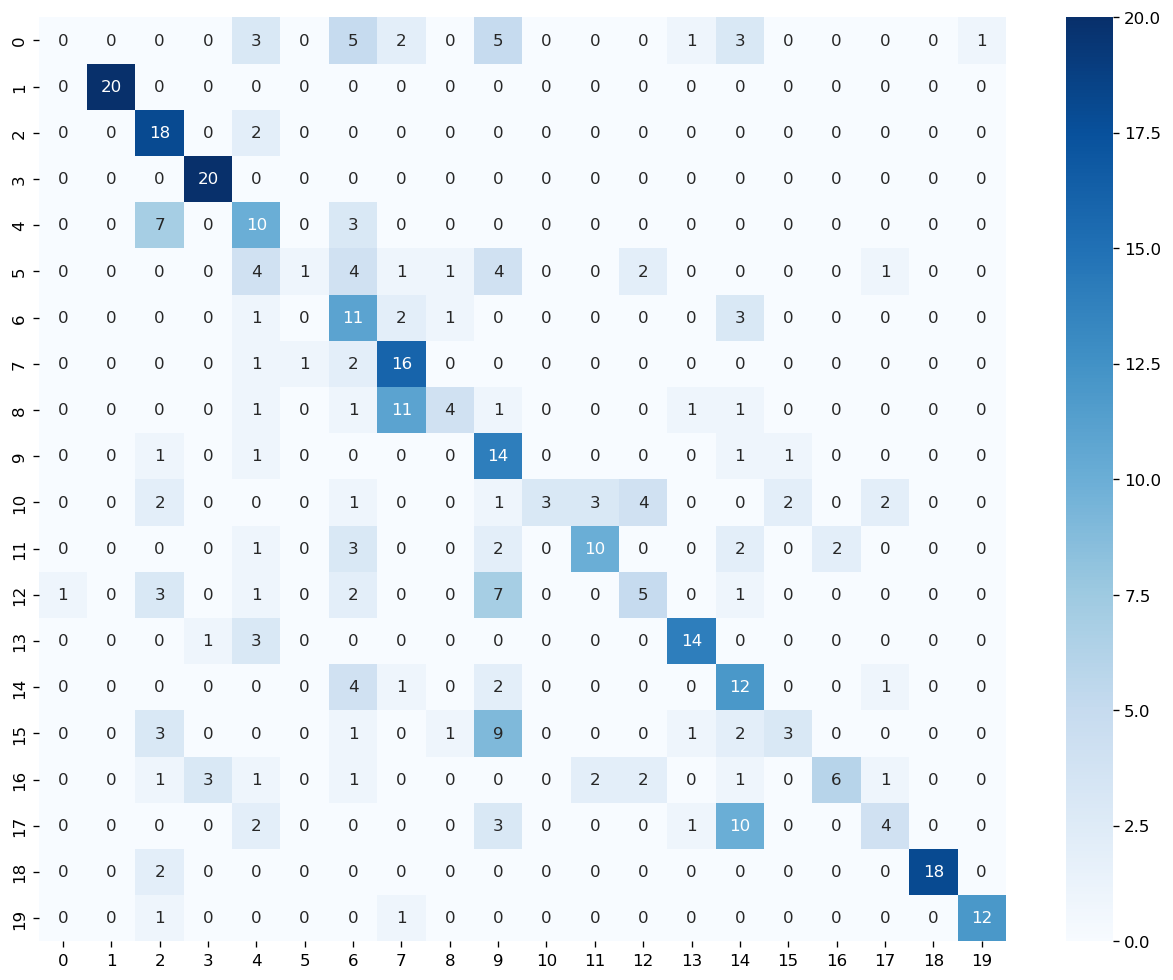

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y,PY)
fig = plt.figure(figsize=(13, 10), dpi=120)
sns.heatmap(cm,annot=True, cmap='Blues')

## TODO

- 固定長に変換
- モデルを少し変える
- 学習